In [ ]:
# Restart the runtime
# !kill -9 -1

In [ ]:
from google.colab import drive  # 40s

drive.mount("/content/drive")

In [ ]:
# 1. Import Libraries 5s
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
# 2. Dataset Loading
dataset_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/a_novel_groundnut_leaf_dataset"
class_names = os.listdir(dataset_path)
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 5
Class names: ['RUST', 'LEAF SPOT (EARLY AND LATE)', 'HEALTHY', 'ALTERNARIA LEAF SPOT', 'ROSETTE']


In [4]:
import os

def count_images_in_subfolders(folder_path):
    image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
    folder_image_counts = {}

    for sub_folder in os.listdir(folder_path):
        sub_folder_path = os.path.join(folder_path, sub_folder)

        if os.path.isdir(sub_folder_path):  # Ensure it's a folder
            image_count = sum(1 for file in os.listdir(sub_folder_path)
                              if os.path.splitext(file)[1].lower() in image_extensions)
            folder_image_counts[sub_folder] = image_count

    return folder_image_counts

folder_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/a_novel_groundnut_leaf_dataset"
folder_counts = count_images_in_subfolders(folder_path)
for folder_name, count in folder_counts.items():
    print(f"Folder '{folder_name}' has {count} images.")

Folder 'RUST' has 120 images.
Folder 'LEAF SPOT (EARLY AND LATE)' has 450 images.
Folder 'HEALTHY' has 600 images.
Folder 'ALTERNARIA LEAF SPOT' has 450 images.
Folder 'ROSETTE' has 100 images.


In [5]:
# 3. Data Preprocessing

images = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))

                original_shape = img.shape
                image_2d = img.reshape(-1, 3)
                scaler = MinMaxScaler(feature_range=(0, 1))
                normalized_2d = scaler.fit_transform(image_2d)
                normalized_image = normalized_2d.reshape(original_shape)

                images.append(normalized_image)
                labels.append(class_name)
            else:
                print(f"Error reading image: {img_path}")

images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)

(1720, 224, 224, 3)
(1720,)


In [6]:
# 4. Label Encoding
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
print(labels_encoded)
print(set(labels_encoded))

[4 4 4 ... 3 3 3]
{0, 1, 2, 3, 4}


In [7]:
# 5. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Train data shape: (1376, 224, 224, 3)
Validation data shape: (172, 224, 224, 3)
Test data shape: (172, 224, 224, 3)


In [8]:
# 6. Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

datagen.fit(X_train)

In [9]:
# 7. Building model
def create_model():
  model = tf.keras.models.Sequential(   # 3s
      [
          tf.keras.layers.Conv2D(
              32, (3, 3), activation="relu", input_shape=(224, 224, 3)
          ),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation="relu"),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(
      optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
  )
  return model

In [1]:
# 8. Model Training with Augmentated Data:
epochs = 75
batch_size = 64
model = create_model()
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),  # Use datagen.flow
    epochs=epochs,
    validation_data=(X_val, y_val),  # Use validation data
    steps_per_epoch=len(X_train) // batch_size  # Calculate steps per epoch
)

NameError: name 'create_model' is not defined

In [14]:
# 9. Model Evaluation:

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss * 100}")
print(f"Test Accuracy: {accuracy * 100}")

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_true = y_test

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Test Loss: 29.808703064918518
Test Accuracy: 91.27907156944275
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Precision: 0.9178
Recall: 0.9128
F1-Score: 0.9121
Accuracy: 91.28%


In [ ]:
# 10. Model Prediction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def image_exists(img_path):
    img = cv2.imread(img_path)
    if img:
      print(img.shape)
      return True
    else:
      return False

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    original_shape = img.shape
    image_2d = img.reshape(-1, 3)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_2d = scaler.fit_transform(image_2d)
    normalized_image = normalized_2d.reshape(original_shape)
    normalized_image = np.expand_dims(normalized_image, axis=0)
    return normalized_image

def display_image_matplotlib(image_path):
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes (optional)
        plt.title("Image Title") # Add a title (optional)
        plt.show()
        return True #Return True if the image was displayed successfully
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return False #Return False if the image was not found
    except Exception as e:
        print(f"An error occurred: {e}")
        return False #Return False if any other error occurred

# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/rust_1/IMG_9015.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/train/nutrition_deficiency_1/35_1.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/healthy_leaf_1/dr_4_1013.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/Groundnut_Leaf_dataset/test/late_leaf_spot_1/dr_4_9915.jpg"
# img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/unknown_predict_images/early_leaf_spot.jpg"
img_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/unknown_predict_images/rust.jpg"

if image_exists(img_path):
    display_image_matplotlib(image_path)
    input_img = preprocess_image(img_path)

    predictions = model.predict(input_img)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    predicted_label = le.inverse_transform([predicted_class])[0]
    print(f"Predicted Disease: {predicted_label}, Confidence: {confidence * 100:.2f}%")
else:
    print("Failed to display the image.")

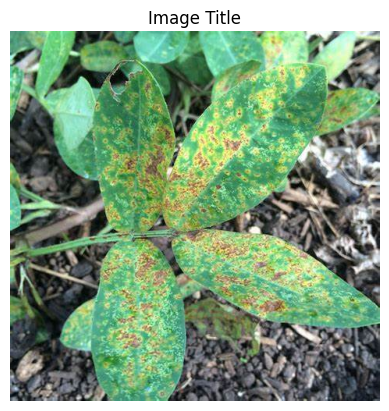

Image displayed successfully.


In [29]:

# Example:
image_path = "/content/drive/MyDrive/Projects/Plant Disease Prediction/unknown_predict_images/rust.jpg"
if display_image_matplotlib(image_path):
    print("Image displayed successfully.")
else:
    print("Failed to display the image.")

In [19]:
# 11. Saving the Model and Label Encoder:

import pickle
models_dir = "/content/drive/MyDrive//Projects/Plant Disease Prediction/saved_models"
os.makedirs(models_dir, exist_ok=True)

model_save_path = os.path.join(models_dir, "921acc_da_groundnut_disease_model.keras")
model.save(model_save_path)

le_save_path = os.path.join(models_dir, "921acc_da_label_encoder.pkl")

with open(le_save_path, "wb") as f:
    pickle.dump(le, f)

# print(f"Model saved to: {model_save_path}")
print(f"Label encoder saved to: {le_save_path}")

Label encoder saved to: /content/drive/MyDrive//Projects/Plant Disease Prediction/saved_models/921acc_da_label_encoder.pkl
